In [119]:
import urllib.request
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers



In [4]:
'''如果本地没有数据集，则从服务器上拉取'''
filePath='./data/titanic.xls'
url = 'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls'
if not os.path.isfile(filePath):
    result=urllib.request.urlretrieve(url,filePath)
    print('success download:'+result)
print('data input success')

data input success


In [5]:
excel=pd.read_excel(filePath)
cols=[
    'pclass','survived','name',	'sex','age','sibsp',
    'parch','ticket','fare','cabin','embarked',	
    'boat',	'body',	'home.dest'
]
print(excel.head(5))

   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

In [6]:
excel_remain=excel.drop(['pclass'],axis=1)#丢弃 ‘pclass’这一列
print(excel_remain.head(5))

   survived                                             name     sex      age  \
0         1                    Allen, Miss. Elisabeth Walton  female  29.0000   
1         1                   Allison, Master. Hudson Trevor    male   0.9167   
2         0                     Allison, Miss. Helen Loraine  female   2.0000   
3         0             Allison, Mr. Hudson Joshua Creighton    male  30.0000   
4         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0000   

   sibsp  parch  ticket      fare    cabin embarked boat   body  \
0      0      0   24160  211.3375       B5        S    2    NaN   
1      1      2  113781  151.5500  C22 C26        S   11    NaN   
2      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64
0    809
1    500
Name: survived, dtype: int64


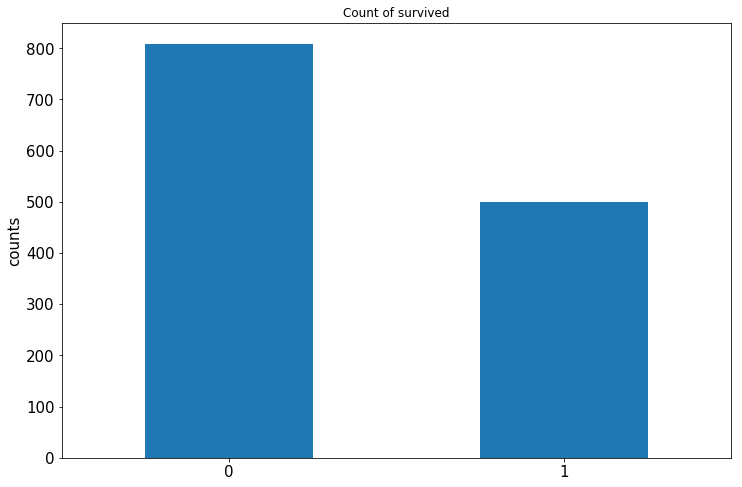

In [7]:
print(excel.isnull().sum())#每一列中的空cell的个数
print(excel['survived'].value_counts())
draft=excel['survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
draft.set_title('Count of survived')
draft.set_ylabel('counts',fontsize=15)
plt.show()

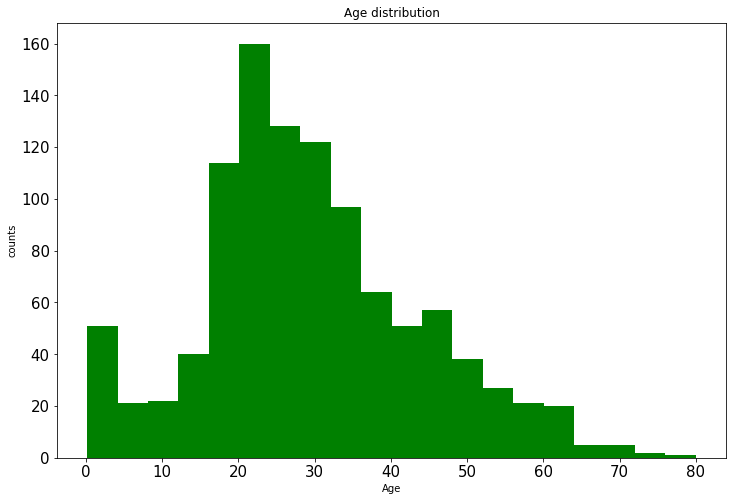

In [8]:
draft=excel['age'].plot(
    kind='hist',figsize=(12,8),bins=20,color='green',
    fontsize=15,rot=0)
draft.set_title('Age distribution')
draft.set_ylabel('counts')
draft.set_xlabel('Age')
plt.show()

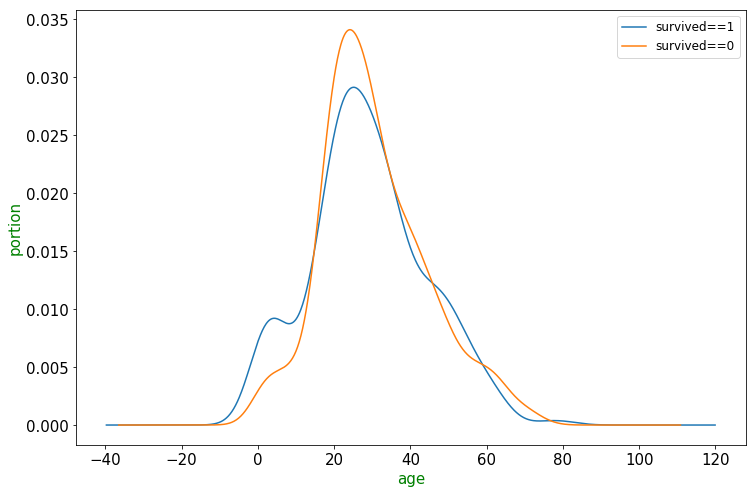

Age distribution of survived and not survived


In [78]:
#把存活的人的age全部获取，把序列画在图（age_sur_die）上,在图中画出存活者年龄分布的密度（占比）
#excel.query('survived==1')['age']#查询符合条件‘survived==1’的年龄，返回的是一个一维序列
age_sur_die=excel.query('survived==1')['age'].plot(
    kind='density',figsize=(12,8),fontsize=15)
excel.query('survived==0')['age'].plot(
    kind='density',figsize=(12,8),fontsize=15)
age_sur_die.set_xlabel('age',fontsize=15,color='green')
age_sur_die.set_ylabel('portion',fontsize=15,color='green')
age_sur_die.legend(['survived==1','survived==0'],fontsize = 12)
plt.show()
print('Age distribution of survived and not survived')


In [125]:
def process(dfdata):
    dfresult=pd.DataFrame()
    
    '''数据的二值化'''
    
    #dfPclass
    dfPclass=pd.get_dummies(dfdata['pclass'])
    dfPclass.columns = ['pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)
    
    #sex
    dfsex=pd.get_dummies(dfdata['sex'])
    #dfresult=pd.concat([dfresult,dfsex],axis=0)#frame的上下拼接
    dfresult=pd.concat([dfresult,dfsex],axis=1)#frame的左右拼接
    
    #Age #年龄特征为int32（从源frame中复制过来）若为空的默认填0，
    dfresult['age']=dfdata['age'].fillna(0)
    dfresult['age_null']=dfdata['age'].isnull().astype('int32')
    
     #SibSp,Parch,Fare
    dfresult['sibsp'] = dfdata['sibsp']
    dfresult['parch'] = dfdata['parch']
    dfresult['fare'] = dfdata['fare']

    #carbin
    #添加“所在船舱是否缺失作为特征”
    dfresult['cabin']=pd.isnull(dfdata['cabin']).astype('int32')
    
    return (dfresult)


process(excel)

,pclass_1,pclass_2,pclass_3,female,male,age,age_null,sibsp,parch,fare,cabin
0,1,0,0,1,0,29.0000,0,0,0,211.3375,0
1,1,0,0,0,1,0.9167,0,1,2,151.5500,0
2,1,0,0,1,0,2.0000,0,1,2,151.5500,0
3,1,0,0,0,1,30.0000,0,1,2,151.5500,0
4,1,0,0,1,0,25.0000,0,1,2,151.5500,0
5,1,0,0,0,1,48.0000,0,0,0,26.5500,0
6,1,0,0,1,0,63.0000,0,1,0,77.9583,0
7,1,0,0,0,1,39.0000,0,0,0,0.0000,0
8,1,0,0,1,0,53.0000,0,2,0,51.4792,0
9,1,0,0,0,1,71.0000,0,0,0,49.5042,1
